In [7]:
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [88]:
from os.path import join

import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import theano
import theano.tensor as tt
import arviz

In [38]:
d = pd.read_csv(join('_data', 'height.csv'))
d = d[d['age'] >= 18]

### Linear regression

In [39]:
endog = d['height']
exog = sm.add_constant(d['weight'])

mod = sm.OLS(endog, exog)
L = mod.fit()

In [40]:
L.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 height   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     463.3
Date:                Sun, 13 Jun 2021   Prob (F-statistic):           4.68e-66
Time:                        15:45:54   Log-Likelihood:                -1071.0
No. Observations:                 352   AIC:                             2146.
Df Residuals:                     350   BIC:                             2154.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        113.8794      1.911     59.589      0.000     110.121     117.638
weight         0.9050      0.042     21.524      0.000       0.822       0.988
==============================================================================
Omnibus:                        5.258   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                5.729
Skew:                          -0.180   Prob(JB):                       0.0570
Kurtosis:                       3.511   Cond. No.                         321.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

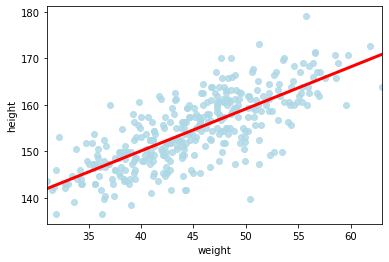

In [68]:
sns.regplot(data=d, x='weight', y='height', ci=None, 
            scatter_kws={'color': 'lightblue'},
            line_kws={'color': 'r', 'linewidth': 3})
plt.show()

### Bayesian regression

In [89]:
x = theano.shared(d['weight'].values)
y = theano.shared(d['height'].values)

In [93]:
nIter = 1000
nChains = 4
nWarmup = 1000

In [94]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', 170, 100)
    beta = pm.Normal('beta', 0, 20)
    sigma = pm.HalfCauchy('sigma', beta=20)
    
    y = pm.Normal('y', mu=alpha + beta * x, sigma=sigma, observed=y)

    trace = pm.sample(nIter, tune=nWarmup, chains=nChains,
                     cores=4, return_inferencedata=True,
                     random_seed=1450154626)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.890728054874645, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7147075292015348, but should be close to 0.8. Try to increase the number of tuning steps.


### Diagnostics

In [95]:
# notice that the values for alpha and beta are the same as 
# the ones estimated using `statsmodels`
with model:
    print(pm.summary(trace).round(2))

         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  113.89  1.90  110.43   117.45       0.06     0.04    1195.0    1649.0   
beta     0.90  0.04    0.83     0.98       0.00     0.00    1196.0    1672.0   
sigma    5.10  0.19    4.72     5.44       0.01     0.00    1244.0     696.0   

       r_hat  
alpha    1.0  
beta     1.0  
sigma    1.0  


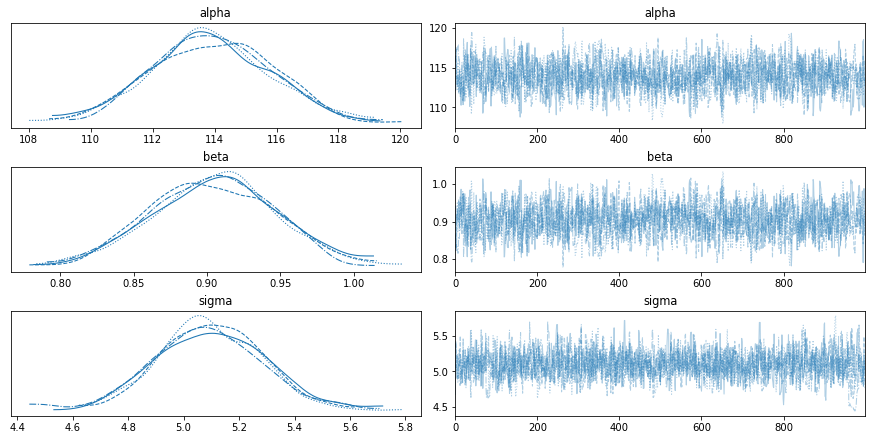

In [96]:
arviz.plot_trace(trace['posterior'])
plt.show()

In [97]:
with model:
    x.set_value(np.asarray([100]))
    ppc = pm.sample_posterior_predictive(trace)